# Report without groud Truth v1.0

## Input prameters

In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e6 else '{:,.1f}'.format(x)

configFile='no_gt_report.config'
parser = ConfigParser()
parser.read(configFile)

no_gt_statistics_unfiltered = parser.get('NOGTReport', 'h5_statistics', fallback='no_gt_statistics_unfiltered.h5')
no_gt_statistics_filtered = parser.get('NOGTReport', 'filtered_h5_statistics', fallback='no_gt_statistics_filtered.h5')
is_somatic = parser.get('NOGTReport', 'is_somatic', fallback=False)
filtered_vcf = parser.get('NOGTReport', 'filtered_vcf',fallback='filtered_vcf.vcf.gz')
interval_list = parser.get('NOGTReport', 'interval_list')
ref_fasta = parser.get('NOGTReport', 'ref_fasta',fallback='Homo_sapiens_assembly38.fasta')
ref_fasta_dict = parser.get('NOGTReport', 'ref_fasta_dict', fallback='Homo_sapiens_assembly38.dict')

NoSectionError: No section: 'NOGTReport'

In [3]:
# import os
# import sys
# home=os.environ['HOME']
# sys.path.append('/home/ubuntu/proj1/VariantCalling/src/')
# from python.utils import revcomp
# import python.vcftools as vcftools
# import python.pipelines.vcf_pipeline_utils as vcf_pipeline_utils
# no_gt_statistics_unfiltered = '/data/mutect2/data_simulation/100x/170469/check_reporrt/no_gt_statistics_unfiltered.h5'
# no_gt_statistics_filtered = '/data/mutect2/data_simulation/100x/170469/check_reporrt/no_gt_statistics_filtered.h5'
# filtered_vcf = '/data/mutect2/data_simulation/100x/170469/check_reporrt/100x_no_chr9.filtered.vcf.gz'
# interval_list = '/data/mutect2/data_simulation/100x/170469/check_reporrt/wgs_calling_regions.hg38.interval_list'
# ref_fasta = '/data/Homo_sapiens_assembly38.fasta'
# ref_fasta_dict = '/data/Homo_sapiens_assembly38.fasta.dict'
# is_somatic = True

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from os.path import join as pjoin
from matplotlib.lines import Line2D

home=os.environ['HOME']
sys.path.append('/VariantCalling/src/')
from python.utils import revcomp
import python.vcftools as vcftools
import python.pipelines.vcf_pipeline_utils as vcf_pipeline_utils

In [5]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 26
TITLE_SIZE = 36
FIGSIZE = (16, 8)
GRID = True
COLORS = [
    "blue",
    "red",
    "green",
    "magenta",
    "black",
    "brown",
    "orange",
    "salmon",
    "teal",
    "coral",
    "lime",
    "purple",
    "cyan",
    "lavender",
    "turquoise",
    "darkgreen",
    "tan",
    "lightblue",
    "pink",
    "yellow",
    "gold",
]

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", grid=GRID)  # is grid on
plt.rc("axes", prop_cycle=plt.cycler(color=COLORS))
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=TITLE_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIGSIZE)  # size of the figure

In [6]:

af_hist = pd.read_hdf(no_gt_statistics_unfiltered,'af_hist')
ins_del_hete = pd.read_hdf(no_gt_statistics_unfiltered,'ins_del_hete')
ins_del_homo = pd.read_hdf(no_gt_statistics_unfiltered,'ins_del_homo')
motifs = pd.read_hdf(no_gt_statistics_unfiltered,'snp_motifs')

filtered_af_hist = pd.read_hdf(no_gt_statistics_filtered,'af_hist')
filtered_ins_del_hete = pd.read_hdf(no_gt_statistics_filtered,'ins_del_hete')
filtered_ins_del_homo = pd.read_hdf(no_gt_statistics_filtered,'ins_del_homo')
filtered_motifs = pd.read_hdf(no_gt_statistics_filtered,'snp_motifs')
#eval
CompOverlap = pd.read_hdf(no_gt_statistics_unfiltered,'eval_CompOverlap')
CountVariants = pd.read_hdf(no_gt_statistics_unfiltered,'eval_CountVariants')
TiTvVariantEvaluator = pd.read_hdf(no_gt_statistics_unfiltered,'eval_TiTvVariantEvaluator')
IndelLengthHistogram = pd.read_hdf(no_gt_statistics_unfiltered,'eval_IndelLengthHistogram')
IndelSummary = pd.read_hdf(no_gt_statistics_unfiltered,'eval_IndelSummary')
MetricsCollection = pd.read_hdf(no_gt_statistics_unfiltered,'eval_MetricsCollection')
ValidationReport = pd.read_hdf(no_gt_statistics_unfiltered,'eval_ValidationReport')
VariantSummary = pd.read_hdf(no_gt_statistics_unfiltered,'eval_VariantSummary')
MultiallelicSummary = pd.read_hdf(no_gt_statistics_unfiltered,'eval_MultiallelicSummary')

filtered_CompOverlap = pd.read_hdf(no_gt_statistics_filtered,'eval_CompOverlap')
filtered_CountVariants = pd.read_hdf(no_gt_statistics_filtered,'eval_CountVariants')
filtered_TiTvVariantEvaluator = pd.read_hdf(no_gt_statistics_filtered,'eval_TiTvVariantEvaluator')
filtered_IndelLengthHistogram = pd.read_hdf(no_gt_statistics_filtered,'eval_IndelLengthHistogram')
filtered_IndelSummary = pd.read_hdf(no_gt_statistics_filtered,'eval_IndelSummary')
filtered_MetricsCollection = pd.read_hdf(no_gt_statistics_filtered,'eval_MetricsCollection')
filtered_ValidationReport = pd.read_hdf(no_gt_statistics_filtered,'eval_ValidationReport')
filtered_VariantSummary = pd.read_hdf(no_gt_statistics_filtered,'eval_VariantSummary')
filtered_MultiallelicSummary = pd.read_hdf(no_gt_statistics_filtered,'eval_MultiallelicSummary')

In [7]:
from IPython.display import display, Markdown

if is_somatic:
    display(Markdown("""# Allele Frequency histogram
    Histogram of 100 bins of Allele fraction for the somatic data. \n
    """))

# Allele Frequency histogram
    Histogram of 100 bins of Allele fraction for the somatic data. 

    

In [8]:
def af_hist_graph(filtered_af_hist):
    nbins = 100
    bin_edges = pd.Series(np.linspace(0, 1, nbins))

    for group in filtered_af_hist.columns:

        #plt.hist(af_hist[group],bin_edges, alpha=0.5, label=group)
        plt.hist(filtered_af_hist[group],bin_edges, alpha=0.5, label=group)##???
        plt.legend(loc='upper right')
        plt.xlabel("Allele Frequency")
    plt.show()


In [9]:
af_hist.value_counts()

0    99
dtype: int64

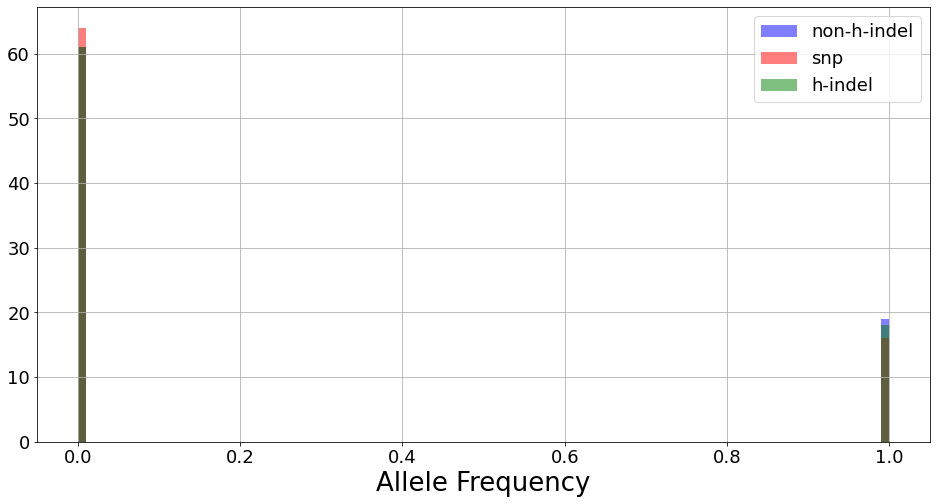

In [10]:
if is_somatic:
    af_hist_graph(filtered_af_hist)

## Insertion Deletion Statistics for h-mer indels
Number of insertions and deletions per base

In [11]:
ins_del_hete.columns = pd.Series(ins_del_hete.columns).apply(lambda x: f"h-mer {x}")
ins_del_homo.columns = pd.Series(ins_del_homo.columns).apply(lambda x: f"h-mer {x}")

## Heterozygous

In [12]:
def ins_del_hete_graph(ins_del, title):
    X = np.arange(12)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(X + 0.00, ins_del.iloc[0], color = 'r', width = 0.3)
    ax.bar(X + 0.3, ins_del.iloc[1], color = 'mediumseagreen', width = 0.3)
    ax.bar(X + 0.00, -ins_del.iloc[2], color = 'purple', width = 0.3)
    ax.bar(X + 0.3, -ins_del.iloc[3], color = 'g', width = 0.3)

    ax.set_title(title)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(pd.Series(np.arange(1,13)).apply(lambda x: f"hmer {x}"))
    ax.legend(labels=['ins A', 'ins G', 'del A', 'del G'])
    ax.set_yticklabels([abs(x) for x in ax.get_yticks()])
    ax.set_ylabel("Deletion                Insertion",

               loc="center")

/home/ubuntu/miniconda3/envs/genomics.py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


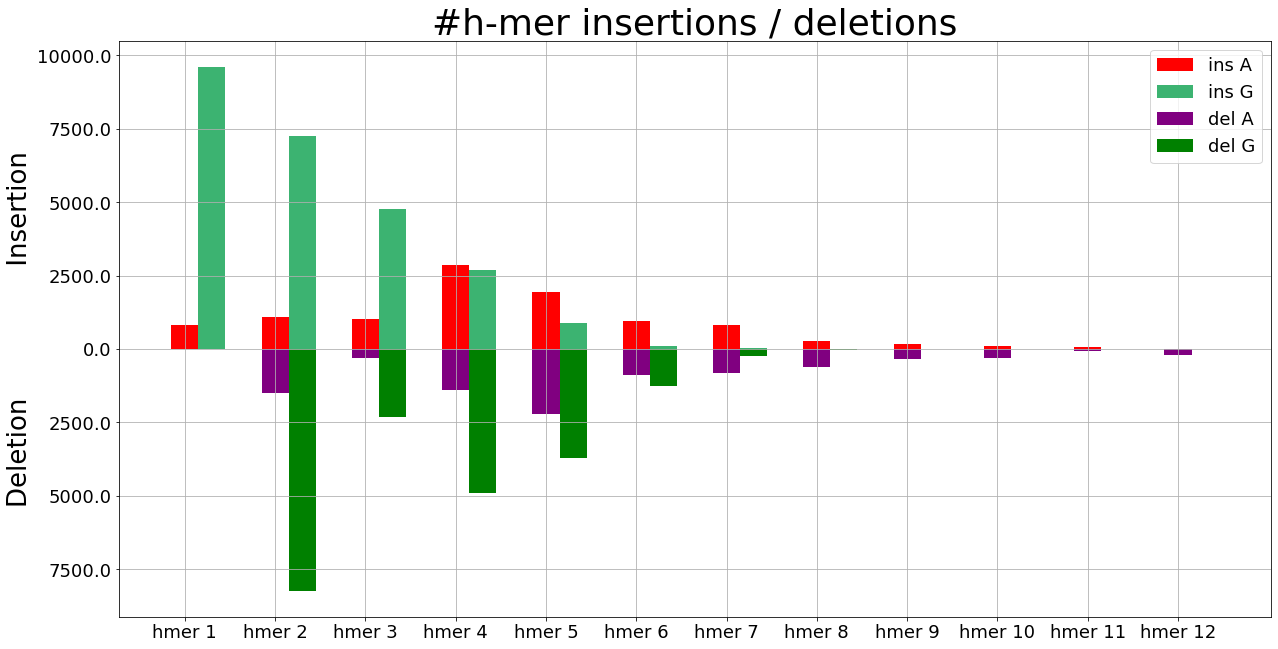

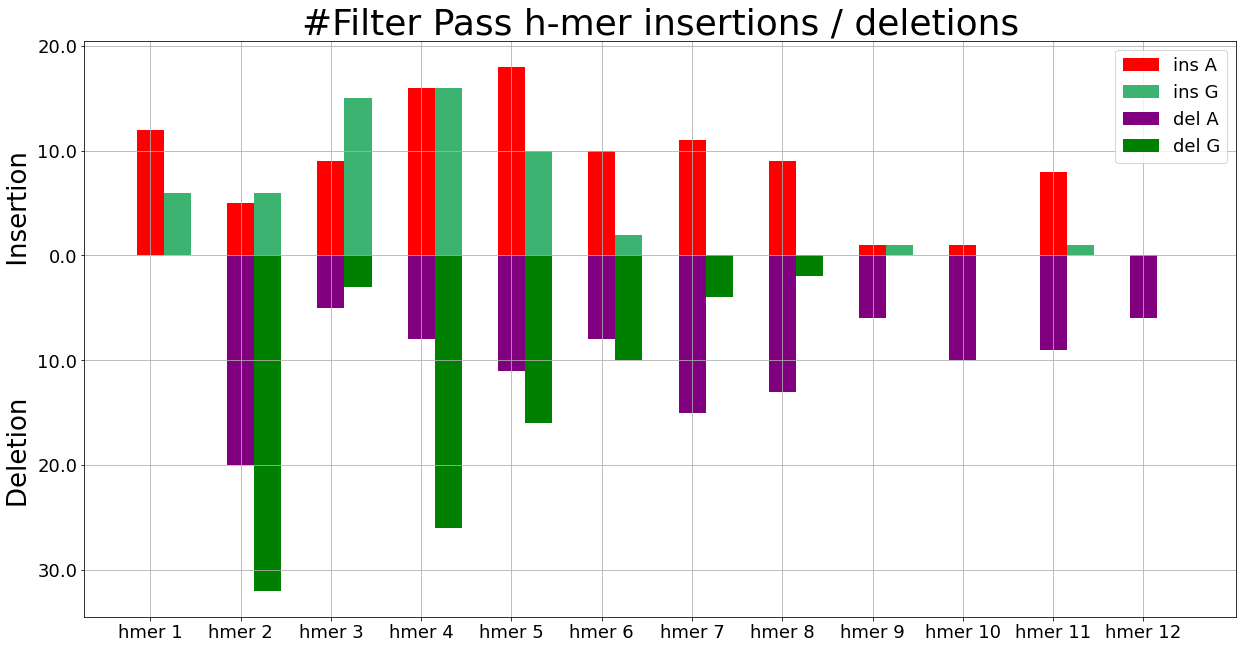

In [13]:
ins_del_hete_graph(ins_del_hete, '#h-mer insertions / deletions')
ins_del_hete_graph(filtered_ins_del_hete, '#Filter Pass h-mer insertions / deletions')

In [14]:
if not is_somatic:
    display(Markdown("""## Homozygous
    """))

In [15]:
if not is_somatic:
    ins_del_hete_graph(ins_del_homo, '# insertions / deletions')
    ins_del_hete_graph(filtered_ins_del_homo, '#Filter Pass insertions / deletions')
    

## Snp statistics
Histogram for motif alterations

In [16]:

base_colors = {"A": "b", "C": "r", "T": "y", "G": "g"}
dpi = 150

def plot_motifs0_bars(motifs_0,ax=None, title_prefix = ""):
    if ax is None:
        plt.figure(figsize=(3, 6))
        ax = plt.gca()
    plt.sca(ax)

    x = (motifs_0).sort_index(ascending=False)
    
    bbox_extra_artists = [
        plt.title(f"{title_prefix} {x.sum():.1E} SNPs".replace("E+0", "E"), fontsize=24)
    ]
    (x / motifs_0.sum() * 100).plot.barh(
        color=[base_colors.get(v) for v in x.index.get_level_values("ref")],
        ax=ax,
    )
    plt.yticks(
        ticks=range(6),
        labels=[
            f"{ref}:{revcomp(ref)}->{alt}:{revcomp(alt)}" for ref, alt in x.index.values
        ],
    )
    for j, (_, row) in enumerate(x.to_frame().iterrows()):
        bbox_extra_artists += [
            plt.text(
                row["size"] / motifs_0.sum() * 101,
                j + 0.03,
                f"{row['size']:.1E}".replace("E+0", "E"),
            )
        ]
    plt.ylabel("")
    plt.xlabel("Frequency [%]")
    # plt.xlim(0, ax.get_xlim()[1]+0.1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return bbox_extra_artists



# plt.savefig(
#     outplot_motif0, dpi=dpi, bbox_inches="tight", bbox_extra_artists=bbox_extra_artists
# )

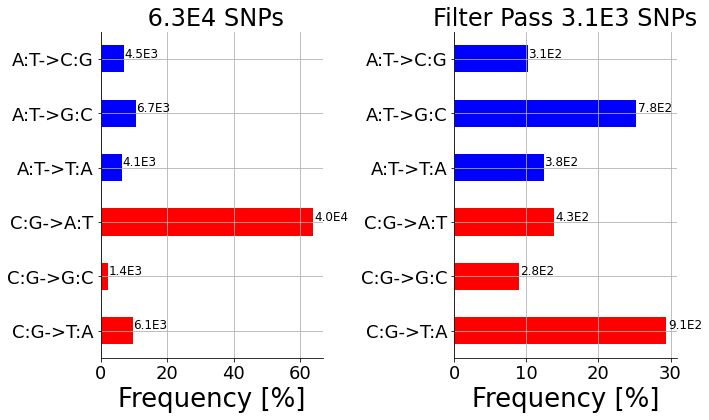

In [17]:
motifs_0 = motifs.reset_index()
motifs_0 = (
    motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
    .groupby(["ref", "alt_1"])
    .agg({"size": "sum"})
)["size"]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))



plot_motifs0_bars(motifs_0, axes[0])

motifs_0 = filtered_motifs.reset_index()
motifs_0 = (
    motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
    .groupby(["ref", "alt_1"])
    .agg({"size": "sum"})
)["size"]

plot_motifs0_bars(motifs_0, axes[1], "Filter Pass")

fig.tight_layout()

## Heatmap
Trinucleotide of Trinucleotide data

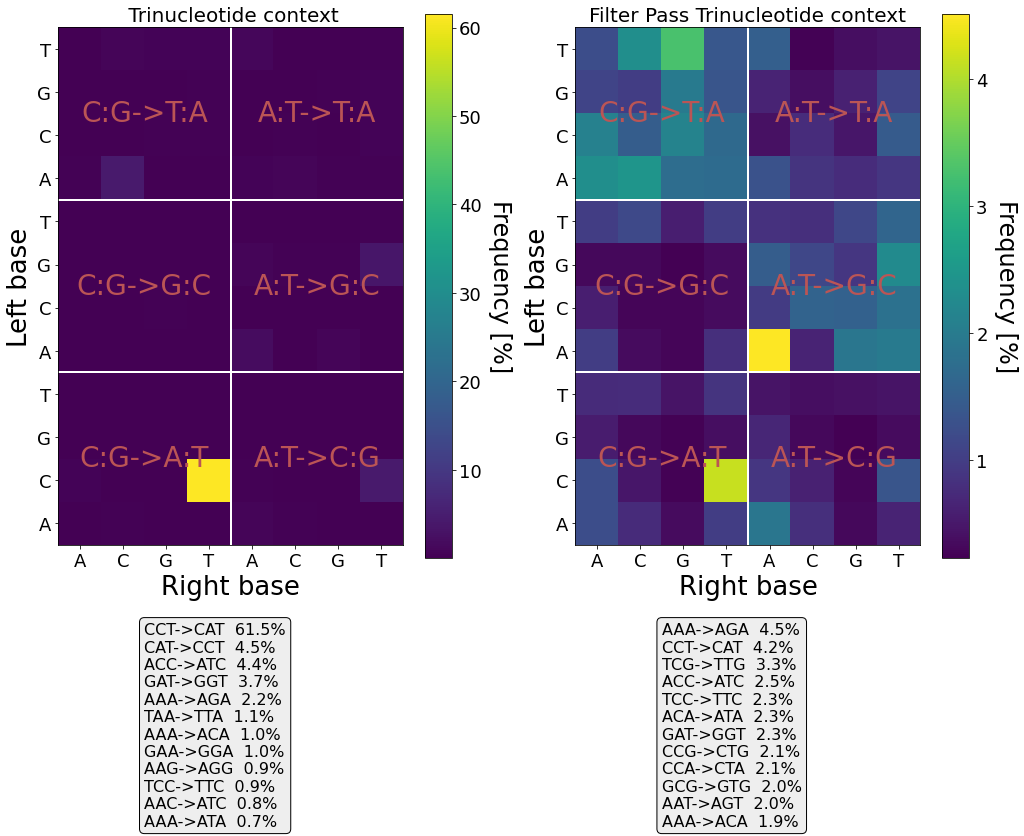

In [18]:
def plot_heatmap(motifs,ax=None, title_prefix = ""):
    
    if ax is None:
        plt.figure()
        ax = plt.gca()
    plt.sca(ax)

    plt.title(f"{title_prefix} Trinucleotide context", fontsize=20)
    
    x = (motifs / motifs.sum()).reset_index()
    x = x.assign(
        ref=x["ref_motif"].str.slice(1, 2),
        alt_motif=x["ref_motif"].str.slice(0, 1)
        + x["alt_1"]
        + x["ref_motif"].str.slice(2),
        left=x["ref_motif"].str.slice(0, 1),
        right=x["ref_motif"].str.slice(2),
    )
    x = x.assign(
        family=x.apply(
            lambda y: f"{y['ref']}:{revcomp(y['ref'])}->{y['alt_1']}:{revcomp(y['alt_1'])}",
            axis=1,
        )
    )
    
    table_str = "\n".join(
        (
            x["ref_motif"]
            + "->"
            + x["alt_motif"]
            + "  "
            + (x["size"]).apply(lambda x: f"{x:.1%}")
        )
        .loc[x.sort_values("size", ascending=False).head(12).index]
        .values
    )
    x = x.pivot_table(
        index=[
            "family",
            "left",
        ],
        columns=["right"],
        values="size",
    ).sort_index(ascending=False)
    
    ax.text(
        0.25,
        -0.15,
        table_str,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="#EEEEEE"),
    )

    bbox_extra_artists = list()
    data = np.concatenate((x.iloc[:12, :], x.iloc[12:, :]), axis=1) * 100
    plt.imshow(data, cmap="viridis")
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().set_ticks(
        range(
            int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs()))),
            1 + int(max(cbar.ax.get_yaxis().get_ticklocs())),
            10 if (int(max(cbar.ax.get_yaxis().get_ticklocs()))-int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs())))>10) else 1))
    cbar.ax.set_ylabel("Frequency [%]", fontsize=24, rotation=270, labelpad=30)
    plt.xticks(range(8), list(x.columns) + list(x.columns))
    plt.yticks(range(12), x.iloc[:12, :].index.get_level_values("left"))
    plt.ylabel("Left base")
    plt.xlabel("Right base")
    plt.grid()
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plt.plot(np.ones(2) * (xlim[0] + (xlim[1] - xlim[0]) / 2), ylim, "-w", linewidth=2)
    plt.plot(xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) / 3), "-w", linewidth=2)
    plt.plot(
        xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) * 2 / 3), "-w", linewidth=2
    )

    X = np.repeat(
        [
            [
                (xlim[0] + (xlim[1] - xlim[0]) / 4),
                (xlim[0] + (xlim[1] - xlim[0]) * 3 / 4),
            ]
        ],
        3,
        axis=0,
    )
    Y = np.repeat(
        [
            [
                (ylim[0] + (ylim[1] - ylim[0]) * 5 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) * 3 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) / 6),
            ]
        ],
        2,
        axis=0,
    ).T
    T = np.vstack(
        (
            x.iloc[:12:4, :].index.get_level_values("family").values,
            x.iloc[12::4, :].index.get_level_values("family").values,
        )
    ).T

    for xx, yy, tt in zip(X.flatten(), Y.flatten(), T.flatten()):
        plt.text(xx, yy, tt, color="#BB5555", fontsize=28, ha="center", va="center")

        
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 10))

plot_heatmap(motifs, axes[0])
plot_heatmap(filtered_motifs, axes[1], "Filter Pass")

# Statistics tables from VariantEval

In [19]:
CompOverlap = CompOverlap.drop(["CompOverlap","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
CompOverlap.columns = pd.Series(CompOverlap.iloc[0])
CompOverlap = CompOverlap[1::].loc[["nEvalVariants","novelSites"]]

filtered_CompOverlap = filtered_CompOverlap.drop(["CompOverlap","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_CompOverlap.columns = pd.Series(filtered_CompOverlap.iloc[0])
filtered_CompOverlap = filtered_CompOverlap[1::].loc[["nEvalVariants","novelSites"]]

In [20]:
CountVariants = CountVariants.drop(["CountVariants","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
CountVariants.columns = pd.Series(CountVariants.iloc[0])
CountVariants = CountVariants[1::].loc[["nDeletions","nInsertions","nSNPs"]]

filtered_CountVariants = filtered_CountVariants.drop(["CountVariants","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_CountVariants.columns = pd.Series(filtered_CountVariants.iloc[0])
filtered_CountVariants = filtered_CountVariants[1::].loc[["nDeletions","nInsertions","nSNPs"]]

In [21]:
TiTvVariantEvaluator = TiTvVariantEvaluator.drop(["TiTvVariantEvaluator","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
TiTvVariantEvaluator.columns = pd.Series(TiTvVariantEvaluator.iloc[0])
TiTvVariantEvaluator = TiTvVariantEvaluator[1::].loc[["nTi","nTv","TiTvRatioStandard"]]

filtered_TiTvVariantEvaluator = filtered_TiTvVariantEvaluator.drop(["TiTvVariantEvaluator","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_TiTvVariantEvaluator.columns = pd.Series(filtered_TiTvVariantEvaluator.iloc[0])
filtered_TiTvVariantEvaluator = filtered_TiTvVariantEvaluator[1::].loc[["nTi","nTv","TiTvRatioStandard"]]

In [22]:
IndelSummary = IndelSummary.drop(["IndelSummary","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
IndelSummary.columns = pd.Series(IndelSummary.iloc[0])
IndelSummary = IndelSummary[1::].loc[[
                       "SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "indel_het_to_hom_ratio",
                       "indel_novelty_rate"
                       ]]

filtered_IndelSummary = filtered_IndelSummary.drop(["IndelSummary","CompFeatureInput","EvalFeatureInput","JexlExpression"], axis=1).transpose()
filtered_IndelSummary.columns = pd.Series(filtered_IndelSummary.iloc[0])
filtered_IndelSummary = filtered_IndelSummary[1::].loc[[
                       "SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "indel_het_to_hom_ratio",
                       "indel_novelty_rate"]]



In [23]:
unfiltered = pd.concat([CompOverlap, CountVariants, TiTvVariantEvaluator, IndelSummary], axis=0)
filtered = pd.concat([filtered_CompOverlap, filtered_CountVariants, filtered_TiTvVariantEvaluator, filtered_IndelSummary], axis=0)

    
merged_df = pd.concat([unfiltered, filtered], axis=1, keys=["unfiltered","filtered"])

if is_somatic:
    merged_df = merged_df.drop(["SNP_het_to_hom_ratio","indel_het_to_hom_ratio"], axis=0)

merged_df

unfiltered               filtered              
Novelty                   all known   novel      all known   novel
nEvalVariants          173361  5301  168060     3981   994    2987
novelSites             168060     0  168060     2987     0    2987
nDeletions              53607  1232   52375      441    74     367
nInsertions             56051   574   55477      291    35     256
nSNPs                   62891  3424   59467     3083   853    2230
nTi                     12713  1358   11355     1654   536    1118
nTv                     50066  2047   48019     1343   301    1042
TiTvRatioStandard        2.00  1.80    2.00     2.00  1.90    2.00
SNP_to_indel_ratio       0.57  1.77    0.55     3.41  4.97    3.05
indel_novelty_rate      98.24  0.00  100.00    81.14  0.00  100.00

## IndelLengthHistogram

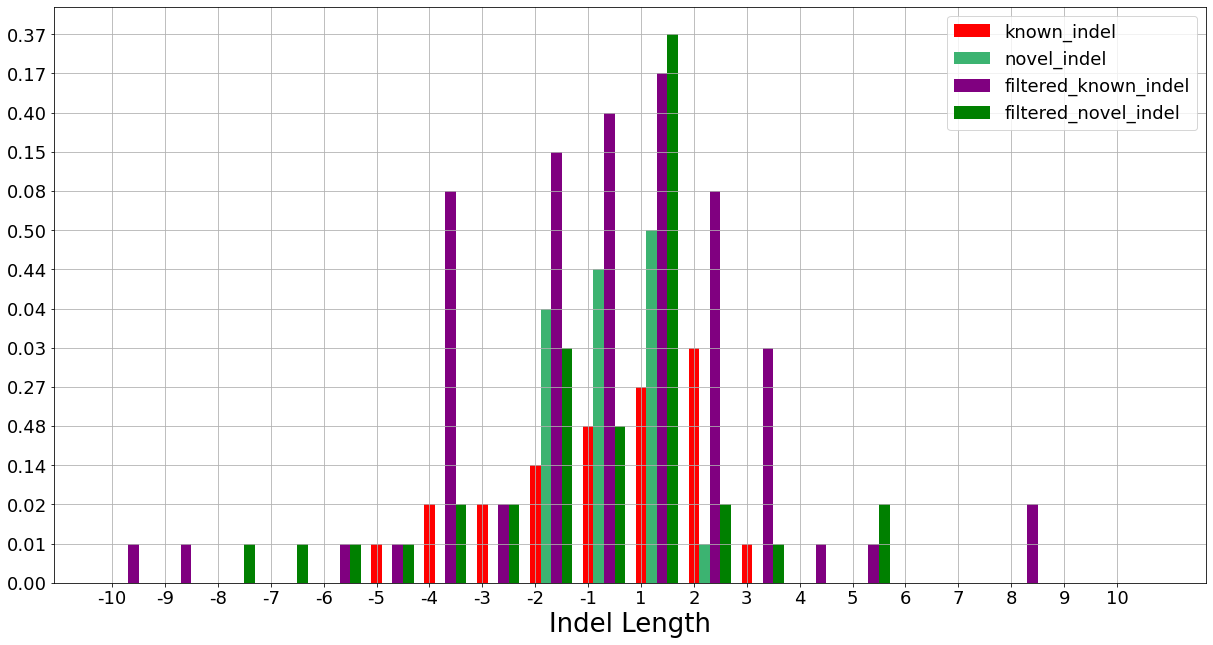

In [24]:
known_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='known']['Freq']
novel_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='novel']['Freq']

filtered_known_indel = filtered_IndelLengthHistogram[filtered_IndelLengthHistogram['Novelty']=='known']['Freq']
filtered_novel_indel = filtered_IndelLengthHistogram[filtered_IndelLengthHistogram['Novelty']=='novel']['Freq']

#filtered_novel_indel

def ins_del_hete_graph(known_indel,novel_indel,filtered_known_indel,filtered_novel_indel, title=None):
    X = np.arange(20)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(X + 0.00, known_indel, color = 'r', width = 0.20)
    ax.bar(X + 0.20, novel_indel, color = 'mediumseagreen', width = 0.20)
    ax.bar(X + 0.40, filtered_known_indel, color = 'purple', width = 0.20)
    ax.bar(X + 0.60, filtered_novel_indel, color = 'g', width = 0.20)

    ax.set_title(title)
    ax.set_xticks(np.arange(0,20))
    ax.set_xticklabels([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10])
    ax.legend(labels=['known_indel', 'novel_indel', 'filtered_known_indel', 'filtered_novel_indel'])
    ax.set_xlabel('Indel Length')
    
ins_del_hete_graph(known_indel,
                   novel_indel,
                   filtered_known_indel,
                   filtered_novel_indel)

# FDR

In [25]:
filtered_vcf_df = vcftools.get_vcf_df(filtered_vcf)

In [26]:
pass_filtered_vcf_df = filtered_vcf_df[filtered_vcf_df['filter']=='PASS']

<!--  ## MetricsCollection -->

In [34]:
def FDR_graph(interval_size,fprs,pass_fps, ax=None,title = None,color='darkorange'):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    plt.sca(ax)
    
    fprs = pd.Series(fprs).dropna()
    pass_fprs = pd.Series(pass_fps).dropna()
    select_size = len(fprs)
    pass_select_size = len(pass_fprs)
    expected_below = fprs*interval_size
    pass_expected_below = pass_fprs*interval_size
    actual = np.arange(select_size)
    pass_actual = np.arange(pass_select_size)
    plt.xlabel('Expected FPR', fontsize=14)
    plt.ylabel('Observed #variants', fontsize=14)
    plt.title(title, fontsize=14)
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['axes.titlesize'] = 30
    params = {'legend.fontsize': 'x-large',
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'large',
             'ytick.labelsize':'large'}
    plt.loglog(expected_below, expected_below,color='royalblue')
    plt.loglog(expected_below, actual,'.',color='darkorange')
    plt.loglog(pass_expected_below, pass_actual,'.',color='green')
    plt.legend(labels=['expected','all', 'pass'])
    plt.grid()
    plt.rcParams.update(params)

In [32]:
interval_obj = vcf_pipeline_utils.IntervalFile(interval_list, ref_fasta, ref_fasta_dict)
interval_size = vcf_pipeline_utils.bed_file_length(interval_obj.as_bed_file())


FileNotFoundError: [Errno 2] No such file or directory: 'picard': 'picard'

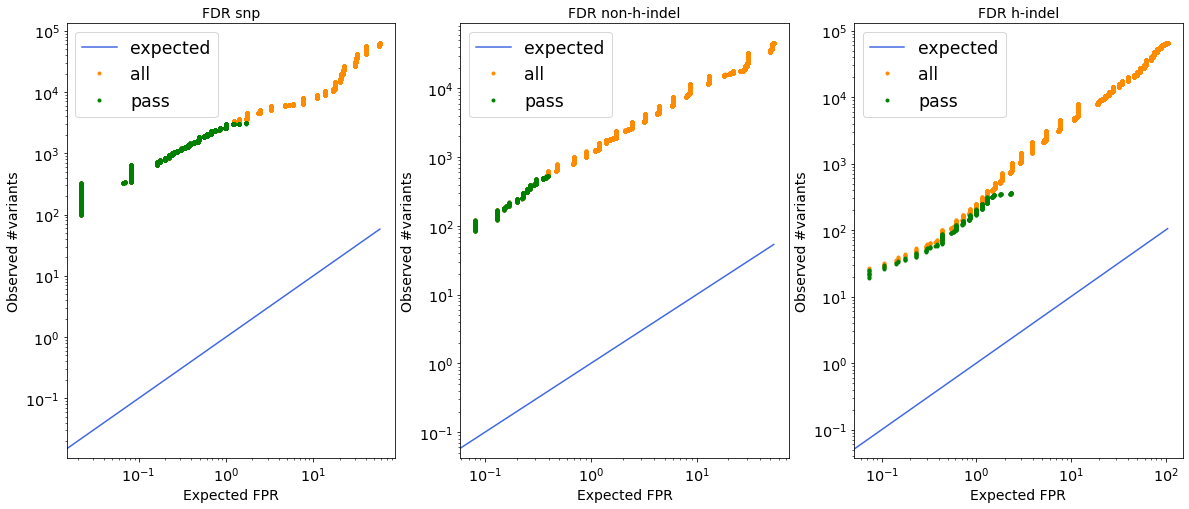

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))
fprs= np.sort(filtered_vcf_df[(filtered_vcf_df['variant_type']=='snp')]['fpr']/(10**6))
pass_fps = np.sort(pass_filtered_vcf_df[(pass_filtered_vcf_df['variant_type']=='snp')]['fpr']/(10**6))
FDR_graph(interval_size,fprs,pass_fps,axes[0],'FDR snp')

fprs= np.sort(filtered_vcf_df[(filtered_vcf_df['variant_type']=='non-h-indel')]['fpr']/(10**6))
pass_fps = np.sort(pass_filtered_vcf_df[(pass_filtered_vcf_df['variant_type']=='non-h-indel')]['fpr']/(10**6))
FDR_graph(interval_size,fprs,pass_fps,axes[1],'FDR non-h-indel')

fprs= np.sort(filtered_vcf_df[(filtered_vcf_df['variant_type']=='h-indel')]['fpr']/(10**6))
pass_fps = np.sort(pass_filtered_vcf_df[(pass_filtered_vcf_df['variant_type']=='h-indel')]['fpr']/(10**6))
FDR_graph(interval_size,fprs,pass_fps,axes[2],'FDR h-indel')
